In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [3]:
#torch.cuda.set_device(2)

In [4]:
torch.backends.cudnn.benchmark=True

## Data

In [5]:
PATH = Path('/home/giles/Downloads/fastai_data/salt/')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [7]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [8]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [9]:
(PATH/'train-128').mkdir(exist_ok=True)

In [10]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [11]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 32
bs = 64
nw = 16

TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 128
bs = 64
nw = 16

In [12]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [13]:
x_names = np.array(glob(f'{PATH}/{TRAIN_DN}/*'))
y_names = np.array(glob(f'{PATH}/{MASKS_DN}/*'))

In [14]:
val_idxs = list(range(800))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [50]:
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS), RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [51]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [52]:
x,y = next(iter(md.trn_dl))

In [53]:
x.shape,y.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 32, 32]))

In [54]:
denorm = md.val_ds.denorm

In [55]:
def show_aug_img(ims, idx, figsize=(5,5), normed=True, ax=None, nchannels=3):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    if normed: ims = denorm(ims)
    else:      ims = np.rollaxis(to_np(ims),1,nchannels+1)
    ax.imshow(np.clip(ims,0,1)[idx])
    ax.axis('off')

In [56]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

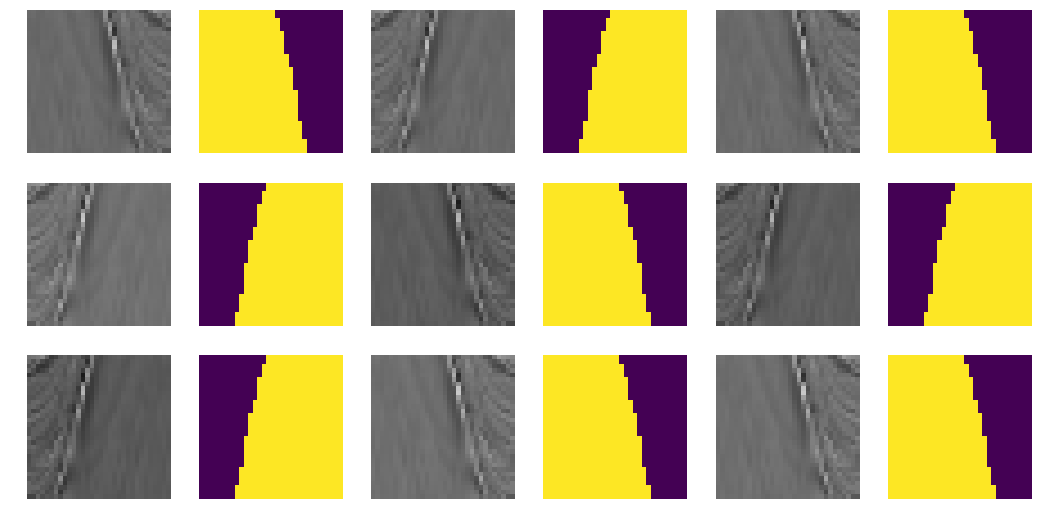

In [57]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    show_aug_img(x,1, ax=axes.flat[i*2])
    show_aug_img(y,1, ax=axes.flat[i*2+1], nchannels=1, normed=False)

## Simple upsample

In [58]:
f = resnet34
cut,lr_cut = model_meta[f]

In [59]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [60]:
def dice(pred, targs):
    pred = (pred>0.5).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## U-net (ish)

In [61]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [62]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [93]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [94]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [95]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [96]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [97]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
                           ('output_shape', [-1, 64, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 8, 8]),
            

In [98]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 16, 16]),
 torch.Size([3, 64, 8, 8]),
 torch.Size([3, 128, 4, 4]),
 torch.Size([3, 256, 2, 2])]

In [99]:
learn.freeze_to(1)

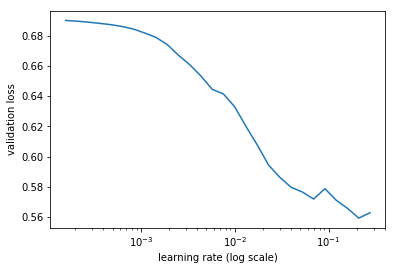

In [100]:
learn.lr_find()
learn.sched.plot()

In [101]:
lr=2e-2
wd=1e-7

lrs = np.array([lr/9,lr/3,lr])

In [102]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.324962   0.35021    0.873533   0.69908   
    1      0.2784     0.244249   0.894323   0.757877       
    2      0.245401   0.258634   0.906572   0.811245       
    3      0.231068   0.244012   0.908881   0.810126       
    4      0.20726    0.226295   0.911876   0.809426       
    5      0.190085   0.212798   0.916592   0.820263       
    6      0.179161   0.246382   0.916816   0.838386       
    7      0.166471   0.222223   0.921831   0.836819       
    8      0.148915   0.217064   0.919303   0.829623       
    9      0.142128   0.210294   0.927793   0.852344       


[array([0.21029]), 0.92779296875, 0.852344447275771]

In [103]:
learn.save('32urn-tmp')

In [104]:
learn.load('32urn-tmp')

In [105]:
learn.unfreeze()
learn.bn_freeze(True)

In [106]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.183886   0.233078   0.906421   0.78914   
    1      0.233754   0.228571   0.90428    0.789016       
    2      0.220028   0.212972   0.912496   0.809266       
    3      0.208927   0.226777   0.903551   0.785285       
    4      0.20269    0.213244   0.90897    0.796054       
    5      0.184726   0.197221   0.923036   0.834551       
    6      0.157264   0.215982   0.916097   0.818172       
    7      0.142905   0.230303   0.91834    0.842702       
    8      0.13617    0.205643   0.926084   0.848377       
    9      0.120178   0.224034   0.922882   0.84252        
    10     0.110852   0.224434   0.920796   0.842043       
    11     0.10254    0.201666   0.928727   0.854405       
    12     0.091366   0.206962   0.929153   0.853166        
    13     0.078525   0.224045   0.933815   0.86077         
    14     0.072085   0.224472   0.930668   0.857304        
    15     0.06976    0.224569   0.931067 

[array([0.23259]), 0.93484375, 0.86206661404237]

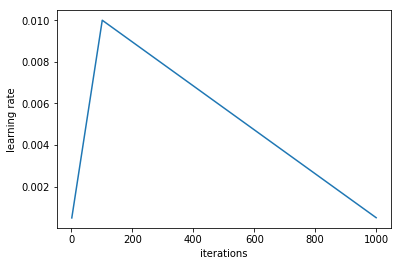

In [107]:
learn.sched.plot_lr()

In [108]:
learn.save('32urn-0')

In [109]:
learn.load('32urn-0')

In [110]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

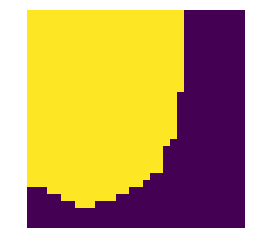

In [111]:
show_img(py[0]>0.5);

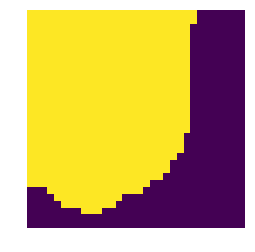

In [112]:
show_img(y[0]);

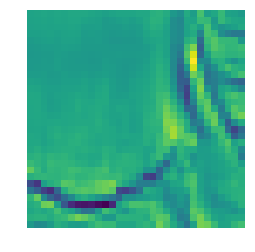

In [113]:
show_img(x[0][0]);

In [114]:
m.close()

## 64x64

In [115]:
sz=64
bs=64

In [116]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [117]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [118]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [119]:
learn.freeze_to(1)

In [120]:
learn.load('32urn-0')

In [121]:
learn.fit(lr/2,1,wds=wd, cycle_len=10,use_clr=(10,10))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.214672   0.202273   0.92298    0.841774  
    1      0.184592   0.19298    0.933186   0.864824       
    2      0.163282   0.160778   0.938561   0.87118        
    3      0.155378   0.177791   0.934208   0.856586       
    4      0.137522   0.164605   0.941956   0.877882       
    5      0.125542   0.164246   0.938013   0.875904       
    6      0.110169   0.170783   0.942333   0.883487       
    7      0.098533   0.156592   0.946172   0.889436        
    8      0.088403   0.166128   0.946232   0.887965        
    9      0.083359   0.163788   0.945189   0.887378        


[array([0.16379]), 0.945189208984375, 0.887378283507889]

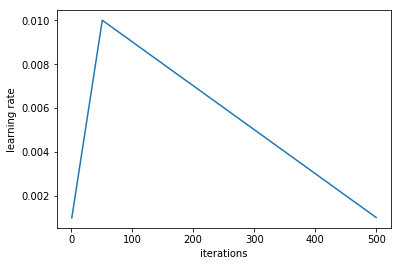

In [122]:
learn.sched.plot_lr()

In [123]:
learn.save('64urn-tmp')

In [124]:
learn.unfreeze()
learn.bn_freeze(True)

In [125]:
learn.load('64urn-tmp')

In [126]:
learn.fit(lrs/2,1,wds=wd, cycle_len=10,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.112993   0.181226   0.933926   0.860897  
    1      0.13811    0.173146   0.93898    0.872428       
    2      0.144502   0.179065   0.93023    0.845505       
    3      0.131877   0.161754   0.94077    0.877714       
    4      0.108722   0.156998   0.942069   0.880905       
    5      0.089146   0.178915   0.943474   0.881318        
    6      0.076669   0.1721     0.947239   0.891213        
    7      0.065926   0.164302   0.948796   0.896314        
    8      0.057186   0.166394   0.949237   0.894631        
    9      0.052058   0.164856   0.950204   0.897039        


[array([0.16486]), 0.9502041625976563, 0.8970389099982785]

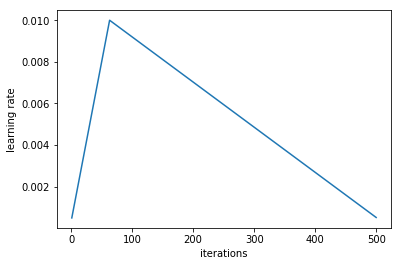

In [127]:
learn.sched.plot_lr()

In [128]:
learn.save('64urn')

In [129]:
learn.load('64urn')

In [130]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

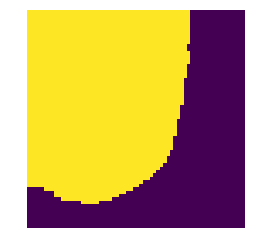

In [131]:
show_img(py[0]>0.5);

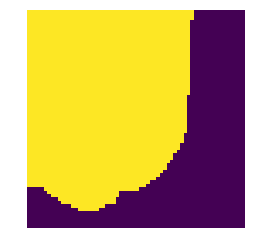

In [132]:
show_img(y[0]);

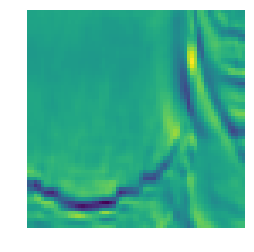

In [133]:
show_img(x[0][0]);

In [134]:
m.close()

## 128x128

In [135]:
sz=128
bs=64

In [136]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [137]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [138]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [143]:
learn.load('64urn')

In [144]:
learn.fit(lr,1, wds=wd, cycle_len=20,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.235286   0.213925   0.904985   0.780341  
    1      0.213068   0.205191   0.925365   0.847028       
    2      0.201061   0.214565   0.906735   0.785073       
    3      0.197201   0.196165   0.915333   0.808492       
    4      0.194718   0.217705   0.926799   0.854681       
    5      0.189814   0.181345   0.925103   0.837034       
    6      0.184731   0.203098   0.929758   0.859548       
    7      0.181192   0.183215   0.927849   0.844512       
    8      0.180008   0.178708   0.928141   0.845589       
    9      0.178967   0.198729   0.930518   0.86047        
    10     0.17898    0.173671   0.931322   0.853096       
    11     0.177963   0.182486   0.923095   0.828533       
    12     0.173883   0.172299   0.934228   0.861305       
    13     0.174484   0.174317   0.933156   0.859927       
    14     0.171829   0.171461   0.934237   0.861346       
    15     0.169839   0.172165   0.935193   0

[array([0.1685]), 0.9354678344726562, 0.8635339673263761]

In [145]:
learn.save('128urn-tmp')

In [151]:
learn.load('128urn-tmp')

In [152]:
learn.unfreeze()
learn.bn_freeze(True)

In [153]:
#lrs = np.array([lr/200,lr/30,lr])

In [154]:
learn.fit(lrs/2,1, wds=wd,cycle_len=20,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.164304   0.183265   0.936747   0.86888   
    1      0.168118   0.172475   0.940095   0.874605       
    2      0.173736   0.18012    0.93844    0.870559       
    3      0.170971   0.16465    0.937557   0.867566       
    4      0.155082   0.161259   0.943512   0.88479        
    5      0.137484   0.162643   0.946288   0.891266       
    6      0.132431   0.135555   0.943414   0.881152       
    7      0.12315    0.150749   0.940678   0.878683       
    8      0.112197   0.14725    0.946756   0.889099       
    9      0.107871   0.15103    0.94216    0.879225       
    10     0.100284   0.165574   0.944151   0.885346        
    11     0.088556   0.186138   0.944975   0.894347        
    12     0.07812    0.164368   0.950222   0.901268        
    13     0.071971   0.151535   0.949113   0.894598        
    14     0.065033   0.159464   0.949534   0.897182        
    15     0.058828   0.151361   0.95376

[array([0.15507]), 0.9560647583007813, 0.9111696812546094]

In [155]:
learn.fit(lrs/4,1, wds=wd,cycle_len=20,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.044711   0.169233   0.953115   0.904108  
    1      0.052504   0.18275    0.943048   0.880533        
    2      0.064954   0.167128   0.945475   0.888785        
    3      0.074445   0.149494   0.950472   0.901322        
    4      0.087099   0.167108   0.948712   0.89515         
    5      0.067779   0.164215   0.954058   0.908001        
    6      0.056488   0.173885   0.947638   0.891305        
    7      0.051785   0.147311   0.952068   0.90278         
    8      0.046906   0.181828   0.948371   0.892407        
    9      0.043116   0.169482   0.951917   0.901949        
    10     0.040238   0.168658   0.951092   0.9013          
    11     0.038863   0.174517   0.953911   0.907278        
    12     0.036227   0.17015    0.954962   0.908292        
    13     0.034701   0.168578   0.95581    0.910242        
    14     0.033597   0.173351   0.954476   0.9068          
    15     0.031654   0.181327

[array([0.19462]), 0.9562998962402344, 0.9111912579154215]

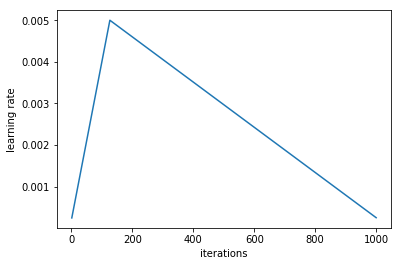

In [156]:
learn.sched.plot_lr()

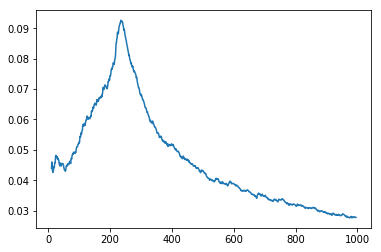

In [157]:
learn.sched.plot_loss()

In [158]:
learn.save('128urn')

In [159]:
learn.load('128urn')

In [160]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

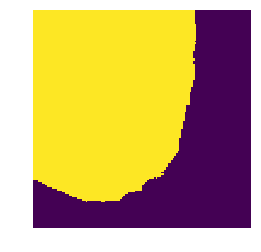

In [161]:
show_img(py[0]>0.5);

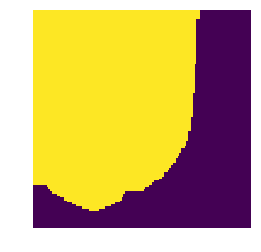

In [162]:
show_img(y[0]);

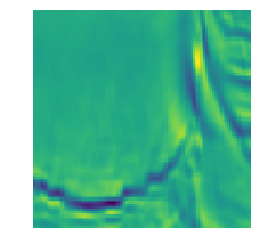

In [163]:
show_img(x[0][0]);

In [164]:
y.shape

torch.Size([64, 128, 128])

In [165]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

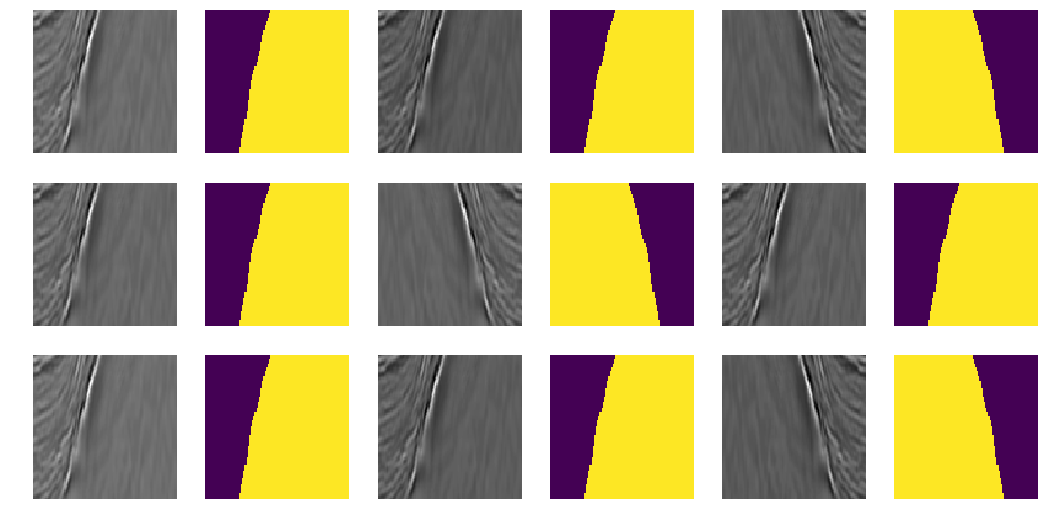

In [166]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    show_aug_img(x,1, ax=axes.flat[i*2])
    show_aug_img(y,1, ax=axes.flat[i*2+1], nchannels=1, normed=False)

# Test on original validation

In [215]:
x_names_orig = np.array(glob(f'{PATH}/train/*'))
y_names_orig = np.array(glob(f'{PATH}/train_masks/*'))

In [216]:
val_idxs_orig = list(range(800))
((val_x_orig,trn_x_orig),(val_y_orig,trn_y_orig)) = split_by_idx(val_idxs_orig, x_names_orig, y_names_orig)

In [217]:
sz=128
bs=64

In [218]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [219]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [220]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [221]:
learn.load('128urn')

In [222]:
probs = learn.predict()

In [223]:
probs.shape

(800, 128, 128)

In [224]:
_, y = learn.TTA(n_aug=1)

In [225]:
y.shape

(800, 128, 128)

In [226]:
idx=0

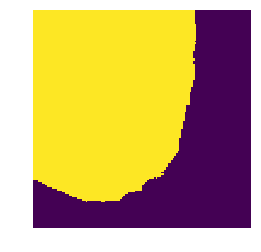

In [227]:
show_img(probs[idx]>0.5);

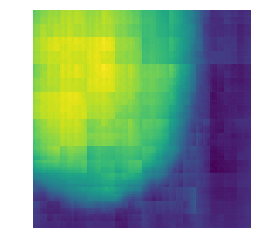

In [228]:
show_img(probs[idx]);

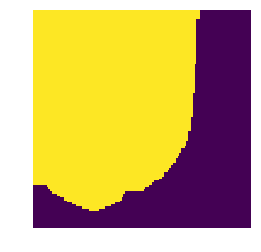

In [229]:
show_img(y[idx]);

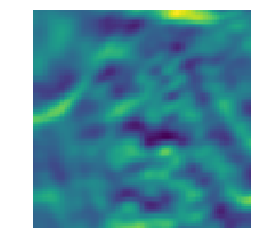

In [230]:
show_img(x[idx][0]);

# Optimise threshold

In [231]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [184]:
thres = np.linspace(-1, 1, 10)
thres_ioc = [iou_metric_batch(y, np.int32(probs > t)) for t in tqdm_notebook(thres)]

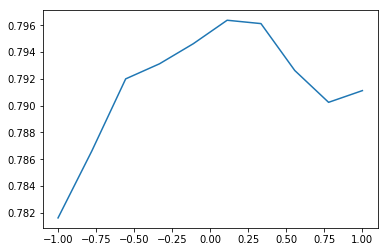

In [185]:
plt.plot(thres, thres_ioc);

In [186]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.11111111111111116, 0.796375)

In [232]:
thres = np.linspace(0, 1, 10)
thres_ioc = [iou_metric_batch(y, np.int32(probs > t)) for t in tqdm_notebook(thres)]

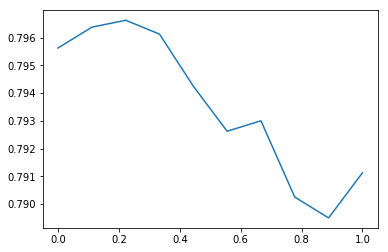

In [233]:
plt.plot(thres, thres_ioc);

In [234]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.2222222222222222, 0.7966250000000001)

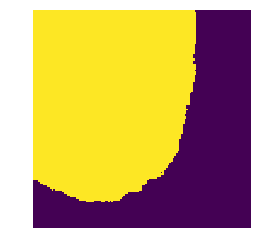

In [235]:
show_img(probs[0]>best_thres);

# Run on test

In [236]:
(PATH/'test-128').mkdir(exist_ok=True)

In [237]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'test-128'/fn.name)

files = list((PATH/'test').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [238]:
testData = np.array(glob(f'{PATH}/test-128/*'))

In [239]:
class TestFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_c(self): return 0

In [240]:
tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(TestFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=testData, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [241]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [242]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [243]:
learn.load('128urn')

In [244]:
x,y = next(iter(md.test_dl))
py = to_np(learn.model(V(x)))

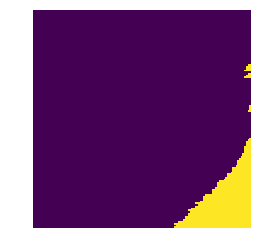

In [245]:
show_img(py[6]>best_thres);

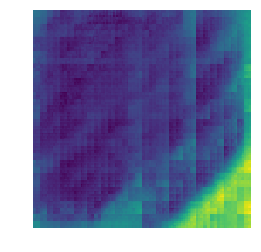

In [246]:
show_img(py[6]);

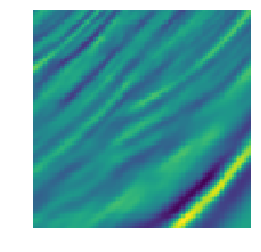

In [247]:
show_img(y[6]);

In [248]:
probs = learn.predict(is_test=True)

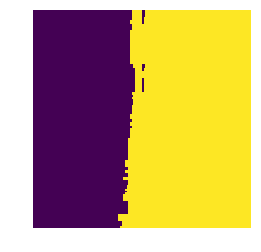

In [249]:
show_img(probs[12]>best_thres);

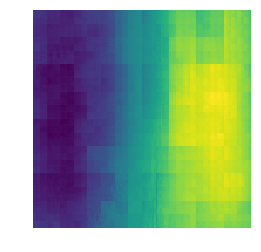

In [250]:
show_img(probs[12]);

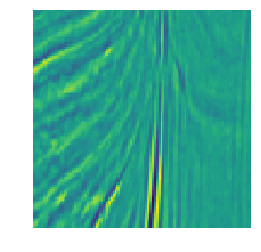

In [251]:
show_img(y[12]);

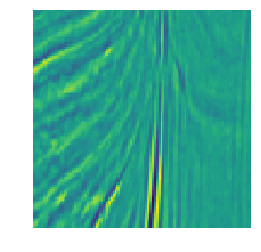

In [252]:
show_img(x[12][0]);

In [253]:
with open(f'{PATH}/probs.pkl', 'wb') as fout: #Save results
    pickle.dump(probs, fout)

In [254]:
probs.shape

(18000, 128, 128)

In [255]:
def resize_img(fn):
    return np.array(Image.fromarray(fn).resize((101,101)))

resizePreds = np.array([resize_img(x) for x in probs])

In [256]:
resizePreds.shape

(18000, 101, 101)

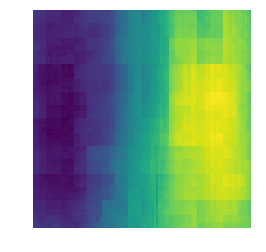

In [257]:
show_img(resizePreds[12]);

In [258]:
testData

array(['/home/giles/Downloads/fastai_data/salt/test-128/ac26efe98e.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/0a5eac8775.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/bdb1c1fcbf.png', ...,
       '/home/giles/Downloads/fastai_data/salt/test-128/3bceaa0303.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/96867a3897.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/52f6267e3f.png'], dtype='<U62')

In [259]:
f'{PATH}/test'

'/home/giles/Downloads/fastai_data/salt/test'

In [260]:
test_ids = next(os.walk(f'{PATH}/test'))[2]

In [261]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [262]:
pred_dict = {id_[:-4]:RLenc(np.round(resizePreds[i] > best_thres)) for i,id_ in tqdm_notebook(enumerate(test_ids))}

In [263]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [264]:
sub

,rle_mask
id,
ac26efe98e,1 39 102 39 203 39 304 39 405 39 506 39 607 37...
0a5eac8775,
bdb1c1fcbf,1 50 64 6 102 28 133 19 168 3 203 25 235 1 238...
5358961921,
b7b72a69d1,
c1169d47ce,
89eb8ef89f,6666 1 6766 2 6865 1 6867 2 6966 4 7066 5 7166...
696d91b37e,
73053e4d03,815 2 1118 1 1219 1 1416 1 1418 1 1516 4 1620 ...
